In [3]:
!pip install together


  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 2.6/2.6 MB 21.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/25.1 MB ? eta -:--:--
   ------------ --------------------------- 7.6/25.1 MB 36.2 MB/s eta 0:00:01
   ------------------------- -------------- 15.7/25.1 MB 36.7 MB/s eta 0:00:01
   --------------------------------- ------ 21.2/25.1 MB 34.4 MB/s eta 0:00:01
   ---------------------------------------  24.9/25.1 MB 32.9 MB/s eta 0:00:01
   ---------------------------------------- 25.1/25.1 MB 27.9 MB/s eta 0:00:00
Using cached shellingham-1.5.4-py2.py3-none-any.whl (9.8 kB)
  Attempting uninstall: pillow
    Found existing installation: pillow 11.0.0
    Uninstalling pillow-11.0.0:
      Successfully uninstalled pillow-11.0.0


  You can safely remove it manually.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import json
import os
from sklearn.metrics import accuracy_score, classification_report
from together import Together

# Together API 클라이언트 설정
client = Together(api_key="")  # API 키를 입력하세요

In [13]:
# 시스템 메시지 및 프롬프트 정의
system_prompt = """
You are a forensic expert who specializes in detecting deepfakes in images. Follow these steps in order to analyze an image:

## 1. Facial Features
- **Alignment and Symmetry**
- **Gaze and Pupils**
- **Unnatural Features**

## 2. Skin Texture and Tone
- **Smoothness and Tone Transitions**
- **Face and Neck Tone**

## 3. Low-Level Details
- **Edges and Borders**
- **Sharpness and Distortion**
- **Shadows and Reflections**

## 4. Lighting and Environment
- **Lighting Coherence**
- **Background Context**

## 5. Deepfake Clues
- **Facial Expressions**
- **Wrinkle Distortions**

---

### **Conclusion**
Focus on these critical aspects to detect inconsistencies and reveal potential deepfake manipulation.

After analyzing, please respond strictly in the following JSON format:

{
    "Result": "fake" or "real",
    "reason": "An explanation of why the image was categorized as fake or real."
}

For each category, tell us more about your observations, noting any anomalies or suspicious elements. If you notice additional clues not listed above, include them in your analysis. Don't miss any important details and be thorough in your assessment.
"""
prompt = """
Analyze the provided image to determine if it is "fake" or "real" based on the criteria listed. Respond STRICTLY in the JSON format specified in the system prompt.

Example:
{
    "Result": "fake",
    "reason": "The image shows mismatched skin tones between the face and neck, overly sharp edges around the eyes and nose, distorted wrinkles near the mouth, and lighting inconsistencies suggesting multiple light sources."
},
{
    "Result": "fake",
    "reason": "The facial features are misaligned, with the eyes appearing asymmetrical, the skin texture overly smooth in certain areas, and the background lighting inconsistent with the shadows on the face."
}




"""

In [6]:
import re
import json
from pydantic import ValidationError
from pydantic import BaseModel, Field, ValidationError
from langchain_together import Together


class PredictionResponse(BaseModel):
    result: str = Field(
        ...,
        alias="Result",
        description="The prediction result, either 'Fake' or 'Real'",
    )
    confidence: float = Field(
        ...,
        alias="confidence",
        ge=0.0,
        le=1.0,
        description="The confidence score between 0 and 1",
    )
    reason: str = Field(
        ...,
        alias="reason",
        description="A concise explanation for why the image is classified as Fake or Real",
    )

    class Config:
        allow_population_by_field_name = True


# JSON 추출 함수
def extract_json(response_text):
    """
    Cleans and fixes invalid JSON responses.
    Removes invalid control characters and fixes multi-line strings in the reason field.
    """
    try:
        # JSON만 추출
        json_match = re.search(r"\{[\s\S]*\}", response_text)
        if json_match:
            json_text = json_match.group()

            # 잘못된 따옴표 수정
            json_text = json_text.replace(""", '"').replace(""", '"')

            # reason 필드의 개행문자와 불필요한 기호 제거
            json_text = re.sub(r"- ", "", json_text)  # 불필요한 '-' 제거
            json_text = re.sub(r"\n\s*", " ", json_text)  # 개행 및 들여쓰기 제거

            # JSON 디코딩
            return json.loads(json_text)
    except json.JSONDecodeError as e:
        print(f"JSON decoding error: {e}")
    return None

c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\ntoday-mK10C09h-py3.12\Lib\site-packages\pydantic\_internal\_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
  warnings.warn(message, UserWarning)


In [9]:
# CSV 파일 읽기
file_path = "test_dataset_final.csv"
df = pd.read_csv(file_path)

# 이미 처리된 이미지를 기록할 파일
processed_file = "processed_images.txt"

# 처리된 이미지 파일 목록 불러오기
if os.path.exists(processed_file):
    with open(processed_file, "r") as f:
        processed_images = set(line.strip() for line in f)
else:
    processed_images = set()

# 결과를 저장할 데이터프레임 생성
results = []

In [10]:
# 각 이미지 처리
for index, row in df.iterrows():
    image_url = row["url"]
    file_name = row["FileName"]
    label = row["Label"]

    # 이미 처리된 경우 건너뛰기
    if file_name in processed_images:
        print(f"Skipping already processed image: {file_name}")
        continue

    print(f"\nProcessing image: {image_url}")

    # API 요청
    try:
        response_generator = client.chat.completions.create(
            model="Qwen/QwQ-32B-Preview",
            messages=[
                {"role": "system", "content": system_prompt},
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                        {"type": "image_url", "image_url": {"url": image_url}},
                    ],
                },
            ],
            temperature=0,
            top_p=0.7,
            top_k=60,
            repetition_penalty=1,
            stop=["<|eot_id|>", "<|eom_id|>"],
            stream=True,  # 스트리밍 활성화
        )

        response_text = ""
        for token in response_generator:
            if hasattr(token, "choices") and token.choices:
                response_text += token.choices[0].delta.content

    except Exception as e:
        print(f"Error processing image {file_name}: {e}")
        continue

    # JSON 응답 추출 및 검증
    response_data = extract_json(response_text)
    if response_data:
        try:
            prediction = PredictionResponse(**response_data)
            model_result = prediction.result
            confidence = prediction.confidence
            reason = prediction.reason  # reason 필드 추가 처리
        except ValidationError as e:
            print(f"Validation error for {file_name}: {e}")
            model_result = "Unknown"
            confidence = 0.0
            reason = "Validation error"
    else:
        print(f"Failed to extract valid JSON for {file_name}")
        print(f"Response text: {response_text}")  # 응답 내용을 출력cjf
        continue

    # 결과 변환
    if model_result.lower() == "fake":
        model_label = 1
    elif model_result.lower() == "real":
        model_label = 0
    else:
        model_label = -1

    results.append(
        {
            "FileName": file_name,
            "url": image_url,
            "Label": label,
            "모델_Label": model_label,
            "Confidence": confidence,
            "Reason": reason,  # reason 필드를 결과에 추가
        }
    )

    # 처리 완료한 이미지를 기록
    with open(processed_file, "a") as f:
        if file_name not in processed_images:
            f.write(f"{file_name}\n")


Processing image: https://raw.githubusercontent.com/KimEunOh/image/main/final_test/1019053_1979-02-28_2006.jpg

Processing image: https://raw.githubusercontent.com/KimEunOh/image/main/final_test/1027753_1885-01-30_1943.jpg

Processing image: https://raw.githubusercontent.com/KimEunOh/image/main/final_test/1083353_1975-09-23_2006.jpg

Processing image: https://raw.githubusercontent.com/KimEunOh/image/main/final_test/1102853_1946-12-03_2008.jpg
Failed to extract valid JSON for 1102853_1946-12-03_2008.jpg
Response text: Alright, I've got this image to analyze for potential deepfake manipulation. I'm going to go through it step by step, checking various aspects to determine if it's real or fake. Let's start with the facial features.

### 1. Facial Features

#### Alignment and Symmetry

First, I'll check for alignment and symmetry in the face. Deepfakes sometimes struggle with perfectly aligning features, leading to slight mismatches that can be clues to manipulation.

- **Observation:** I

In [11]:
# 리스트를 DataFrame으로 변환
results_df = pd.DataFrame(results)

# 기존 결과 병합
output_file = "Test_dataset_results_QwQ.csv"
if os.path.exists(output_file) and os.stat(output_file).st_size > 0:
    try:
        existing_results = pd.read_csv(output_file)
    except pd.errors.EmptyDataError:
        existing_results = pd.DataFrame()
else:
    existing_results = pd.DataFrame()

results_df = pd.concat(
    [existing_results, results_df], ignore_index=True
).drop_duplicates(subset=["FileName"])

# 결과 저장
results_df.to_csv(output_file, index=False, encoding="utf-8-sig")
print(f"\nProcessed results saved to {output_file}")


Processed results saved to Test_dataset_results_QwQ.csv



Model Accuracy: 48.24%

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        88
           1       0.48      1.00      0.65        82

    accuracy                           0.48       170
   macro avg       0.24      0.50      0.33       170
weighted avg       0.23      0.48      0.31       170


Confusion Matrix:
[[ 0 88]
 [ 0 82]]


c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\ntoday-mK10C09h-py3.12\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\ntoday-mK10C09h-py3.12\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\ntoday-mK10C09h-py3.12\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

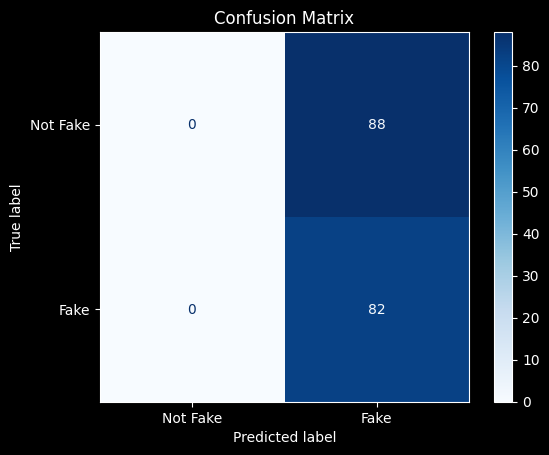

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# 정확도 계산
valid_results = results_df[results_df["모델_Label"] != -1]  # 유효한 결과만 필터링
accuracy = accuracy_score(valid_results["Label"], valid_results["모델_Label"])
print(f"\nModel Accuracy: {accuracy:.2%}")

# 추가적인 정밀도, 재현율, F1 점수 계산
print("\nClassification Report:")
print(classification_report(valid_results["Label"], valid_results["모델_Label"]))

# 혼동 행렬 계산
cm = confusion_matrix(valid_results["Label"], valid_results["모델_Label"])
print("\nConfusion Matrix:")
print(cm)

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fake", "Fake"])
disp.plot(cmap="Blues")  # 색상 지도 설정
plt.title("Confusion Matrix")
plt.show()